# Analysis of 1/48 Deg global ocean run
Relevant links -

https://medium.com/pangeo/petabytes-of-ocean-data-part-1-nasa-ecco-data-portal-81e3c5e077be 

https://xmitgcm.readthedocs.io/en/latest/llcreader.html

https://pangeo-data.github.io/pangeo-datastore/master/ocean/llc4320.html#llc4320-grid

https://ecco.jpl.nasa.gov/products/latest/user-guide/

In [8]:
import xarray as xr
import dask.array as da
#from dask.distributed import Client, LocalCluster
from xgcm import Grid
import xrft
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from xmitgcm import llcreader
import intake
import os
%matplotlib inline

In [9]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster, make_pod_spec

pod_spec = make_pod_spec(image='daskdev/dask:latest', memory_limit='7G', memory_request='4G', cpu_limit=1, cpu_request=1,
                         env={'EXTRA_PIP_PACKAGES': 'fastparquet git+https://github.com/dask/distributed git+https://github.com/MITgcm/xmitgcm.git'})
cluster = KubeCluster(pod_spec)

cluster.scale(4)
#cluster.adapt(minimum=1, maximum=10, interval='500ms')

# ----- below are not working ------------
#cluster = KubeCluster(env={'PATH': '/home/jovyan/my-conda-envs/my-pangeo/bin:$PATH'})
#cluster = KubeCluster(env={'NB_PYTHON_PREFIX':sys.prefix})
#cluster.scale(4)

#cluster = KubeCluster(n_workers=8)
#cluster.adapt(minimum=1, maximum=10)

cluster

distributed.scheduler - INFO - Clear task state
/home/jovyan/my-conda-envs/my-pangeo/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:    tcp://10.32.5.72:46543
distributed.scheduler - INFO -   dashboard at:                    :42161


distributed.scheduler - INFO - Register tcp://10.32.3.9:33279
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.3.9:33279
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.20.5:46003
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.20.5:46003
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.20.6:42753
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.20.6:42753
distributed.core - INFO - Starting established connection


In [10]:
client = Client(cluster)
client

client.get_versions(check=True)
client.run(lambda: os.environ)

distributed.scheduler - INFO - Receive client connection: Client-417b58ec-2040-11ea-81a8-86992f78e425
distributed.core - INFO - Starting established connection


{'tcp://10.32.20.5:46003': environ{'KUBERNETES_SERVICE_PORT_HTTPS': '443',
         'KUBE_LEGO_NGINX_PORT': 'tcp://10.4.11.84:8080',
         'KUBERNETES_SERVICE_PORT': '443',
         'PROXY_API_SERVICE_HOST': '10.4.4.147',
         'HOSTNAME': 'dask-0000-0001-6559-9059-7d8e089f-b6xtnl',
         'DASK_SCHEDULER_ADDRESS': 'tcp://10.32.5.72:46543',
         'PROXY_API_SERVICE_PORT': '8001',
         'PROXY_HTTP_PORT_8000_TCP_ADDR': '10.4.5.195',
         'PROXY_PUBLIC_PORT_80_TCP': 'tcp://10.4.6.187:80',
         'PROXY_PUBLIC_PORT': 'tcp://10.4.6.187:80',
         'PROXY_PUBLIC_SERVICE_PORT_HTTP': '80',
         'PWD': '/',
         'KUBE_LEGO_NGINX_SERVICE_PORT': '8080',
         'PROXY_API_PORT_8001_TCP_ADDR': '10.4.4.147',
         'HUB_SERVICE_HOST': '10.4.7.140',
         'HOME': '/root',
         'LANG': 'C.UTF-8',
         'KUBERNETES_PORT_443_TCP': 'tcp://10.4.0.1:443',
         'PROXY_HTTP_SERVICE_PORT': '8000',
         'PROXY_HTTP_PORT_8000_TCP_PORT': '8000',
         'PROX

In [11]:
# Load data from web
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")
dsgrid = cat["LLC4320_grid"].to_dask()
dsgrid = llcreader.faces_dataset_to_latlon(dsgrid, metric_vector_pairs=[('dxC', 'dyC'), ('dyG', 'dxG')])

model = llcreader.ECCOPortalLLC4320Model()
#ds = model.get_dataset(varnames=['U','V'], k_levels=[1,3,5,10,30],type='latlon')
ds = model.get_dataset(varnames=['U','V'], k_levels=[1],type='latlon') #,k_chunksize=5)

ds = xr.merge([ds, dsgrid])
ds = ds.isel(time = np.arange(0, 1)) #len(ds.time), 12))

print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k: 1, k_l: 1, k_p1: 2, k_u: 1, time: 1)
Coordinates:
  * k_p1     (k_p1) int64 0 1
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * k_u      (k_u) int64 1
  * k_l      (k_l) int64 1
  * k        (k) int64 1
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4017
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>

In [12]:
# Create grid and compute vorticity, divergence
grid = Grid(ds, coords={'X': {'center': 'i', 'right': 'i_g'}, 'Y': {'center': 'j', 'right': 'j_g'}}, periodic=['X'])

#ds1 = model.get_dataset(varnames=['W'], type='latlon')
#grid1 = Grid(ds1, coords={'X': {'center': 'i', 'right': 'i_g'}, 'Y': {'center': 'j', 'right': 'j_g'}, 'Z': {'center': 'k', 'outer': 'k_l'}})
#ds1 = xr.merge([ds1, dsgrid])

# Compute vorticity and divergence 
vorticity = ( - grid.diff(ds.U * ds.dxC, 'Y', boundary='fill') 
              + grid.diff(ds.V * ds.dyC, 'X', boundary='fill') ) / ds.rAz

divergence =  ( grid.diff(ds.U * ds.dxC, 'X', boundary='fill') 
              + grid.diff(ds.V * ds.dyC, 'Y', boundary='fill') ) / ds.rA

In [13]:
# Select data for a small region
lat1, lat2 = (30., 40.); # 10x10 deg box near gulf stream
lon1, lon2 = (-120.,-110.); # 1 deg should be avoided on each side for the final data

u1 = grid.interp(ds.U, 'X', boundary='fill')
v1 = grid.interp(ds.V, 'Y', boundary='fill')
vort = grid.interp(grid.interp(vorticity, 'X', boundary='fill'), 'Y', boundary='fill')

distributed.scheduler - INFO - Register tcp://10.32.21.11:42651
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.21.11:42651
distributed.core - INFO - Starting established connection


In [14]:
# Identify indices of lat, lon limits. I chose a fixed row/column in lats/lons to find the indices. Make sure the results do not change significantly 
#lats = (client.compute(ds.YC)).values
#lats = client.compute(ds.YC[0]).result()
#lats = lats.result()
idx_lat1 = (np.abs(ds.YC.isel(i=8000).values - lat1)).argmin()
idx_lat2 = (np.abs(ds.YC.isel(i=8000).values - lat2)).argmin()

#lons = ds.XC.persist()
#idx_lon1 = (np.abs(lons[8000,:] - lon1)).argmin()
#idx_lon2 = (np.abs(lons[8000,:] - lon2)).argmin()

distributed.scheduler - INFO - Remove worker tcp://10.32.20.5:46003
distributed.core - INFO - Removing comms to tcp://10.32.20.5:46003
distributed.scheduler - INFO - Remove worker tcp://10.32.20.6:42753
distributed.core - INFO - Removing comms to tcp://10.32.20.6:42753
distributed.scheduler - INFO - Register tcp://10.32.20.5:46003
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.20.5:46003
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.20.6:42753
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.20.6:42753
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Remove worker tcp://10.32.21.11:42651
distributed.core - INFO - Removing comms to tcp://10.32.21.11:42651
distributed.scheduler - INFO - Remove worker tcp://10.32.20.5:46003
distributed.core - INFO - Removing comms to tcp://10.32.20.5:46003
distributed.scheduler - INFO - Register tcp:

KilledWorker: ('zarr-5ab0dd64d017657b8dd16d99c305ea12', <Worker 'tcp://10.32.20.5:46003', memory: 0, processing: 1>)

In [57]:
# Extract data for the selected lat-lon domain
vort2 = vort.isel({'j': slice(idx_lat1, idx_lat2), 'i' : slice(idx_lon1, idx_lon2)})
u2 = u1.isel({'j': slice(idx_lat1, idx_lat2), 'i' : slice(idx_lon1, idx_lon2)})
v2 = v1.isel({'j': slice(idx_lat1, idx_lat2), 'i' : slice(idx_lon1, idx_lon2)})
div2 = divergence.isel({'j': slice(idx_lat1, idx_lat2), 'i' : slice(idx_lon1, idx_lon2)})
lat = ds.YC.isel({'j': slice(idx_lat1, idx_lat2), 'i' : slice(idx_lon1, idx_lon2)})
lon = ds.XC.isel({'j': slice(idx_lat1, idx_lat2), 'i' : slice(idx_lon1, idx_lon2)})

In [ ]:
# Compute wavenumbers 
R = 6364.e3; # Raidus of the Earth


In [21]:
lats = client.compute(ds.YC.isel(i=8000))
#Client.publish(lats=lats)
#print(client.result(lats))
#print(lats[:,0])
#print(lons[:,100])
#print(idx_lat1, idx_lat2, idx_lon1, idx_lon2)

In [24]:
pods = cluster.pods()
print(cluster.logs(pods[0]))

AttributeError: 'KubeCluster' object has no attribute 'pods'

distributed.scheduler - INFO - Register tcp://10.32.8.3:40193
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.8.3:40193
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.8.2:45107
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.8.2:45107
distributed.core - INFO - Starting established connection


In [10]:
#tmp = lats.compute()
#print(tmp)
print(idx_lat1.values, idx_lat2.values)

distributed.scheduler - INFO - Remove worker tcp://10.32.20.6:34351
distributed.core - INFO - Removing comms to tcp://10.32.20.6:34351
distributed.scheduler - INFO - Register tcp://10.32.20.6:34351
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.20.6:34351
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Remove worker tcp://10.32.26.6:43699
distributed.core - INFO - Removing comms to tcp://10.32.26.6:43699
distributed.scheduler - INFO - Register tcp://10.32.26.6:43699
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.26.6:43699
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Remove worker tcp://10.32.20.6:34351
distributed.core - INFO - Removing comms to tcp://10.32.20.6:34351
distributed.scheduler - INFO - Register tcp://10.32.20.6:34351
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.20.6:34351
distributed.core - INFO - Starti

KilledWorker: ('zarr-21e7c2cadcb65c8831b06ca18cf43068', <Worker 'tcp://10.32.26.6:43699', memory: 0, processing: 1>)

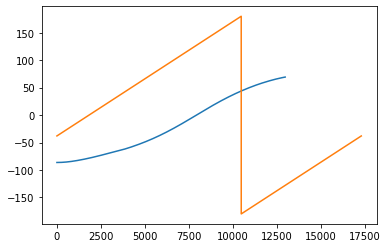

In [41]:
plt.plot(lats[:,8000])
plt.plot(lons[8000,:])

In [27]:
ds.nbytes/1e12

72.817400846196

In [28]:
ds.close()

In [23]:
x = da.random.random((50000,50000), chunks=(2000,2000))
x.persist()

dask.array<random_sample, shape=(50000, 50000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

NameError: name 'x' is not defined